In [10]:
using Plots
using .Threads

println("Number of threads $(nthreads())")

Number of threads 4


In [11]:
a = zeros(Int, 12)

@threads for i = eachindex(a)
    a[i] = threadid()
end

a

12-element Vector{Int64}:
 1
 1
 1
 2
 2
 2
 4
 4
 4
 3
 3
 3

# Gray-Scott system

$$
\begin{aligned}
\frac{\partial u}{\partial t} & = D\_u \Delta u - uv^2 + F(1-u) \\\\ 
\frac{\partial v}{\partial t} & = D\_v \Delta v + uv^2 - (F+k)v 
\end{aligned} 
$$

## Laplacian 

$$
\Delta u\_{i,j} \approx u\_{i,j-1} + u\_{i-1,j} -4u\_{i,j} + u\_{i+1, j} + u\_{i, j+1} 
$$

- Euler scheme is used to integrate the time derivative.  

## Initial conditions

- ``u`` is 1 everywhere and ``v`` is 0 in the domain except in a square zone where ``v = 0.25`` and ``u = 0.5``. This square located in the center of the domain is  $[0, 1]\times[0,1]$ with a size of ``0.2``.

In [12]:
const Dᵤ = .1
const Dᵥ = .05
const F = 0.0545
const k = 0.062

function init(n)
 
    u = ones((n+2,n+2))
    v = zeros((n+2,n+2))
    
    x, y = LinRange(0, 1, n+2), LinRange(0, 1, n+2)

    for j in eachindex(y), i in eachindex(x)
        if (0.4<x[i]) && (x[i]<0.6) && (0.4<y[j]) && (y[j]<0.6)
            u[i,j] = 0.50
            v[i,j] = 0.25
        end
    end
        
    return u, v
    
end

init (generic function with 1 method)

## Serial function

In [21]:
function grayscott!( u, v, Δu, Δv)

    for c = axes(Δu, 2)
        c1 = c + 1
        c2 = c + 2
        for r = axes(Δu, 1)
            r1 = r + 1
            r2 = r + 2
            Δu[r,c] = u[r1,c2] + u[r1,c] + u[r2,c1] + u[r,c1] - 4*u[r1,c1]
            Δv[r,c] = v[r1,c2] + v[r1,c] + v[r2,c1] + v[r,c1] - 4*v[r1,c1]
        end
    end

    for c = axes(Δu, 2)
        c1 = c + 1
        for r = axes(Δu, 1)
            r1 = r + 1  
            uvv = u[r1,c1]*v[r1,c1]*v[r1,c1]
            u[r1,c1] +=  Dᵤ * Δu[r,c] - uvv + F*(1 - u[r1,c1])
            v[r1,c1] +=  Dᵥ * Δv[r,c] + uvv - (F + k)*v[r1,c1]
        end
    end

end

grayscott! (generic function with 1 method)

# Simulation

 26.085266 seconds (93.79 M allocations: 12.823 GiB, 3.87% gc time)


[ Info: Saved animation to /Users/navaro/JuliaProjects/CargoChatJulia2024/anim1.gif


Plots.AnimatedGif("/Users/navaro/JuliaProjects/CargoChatJulia2024/anim1.gif")
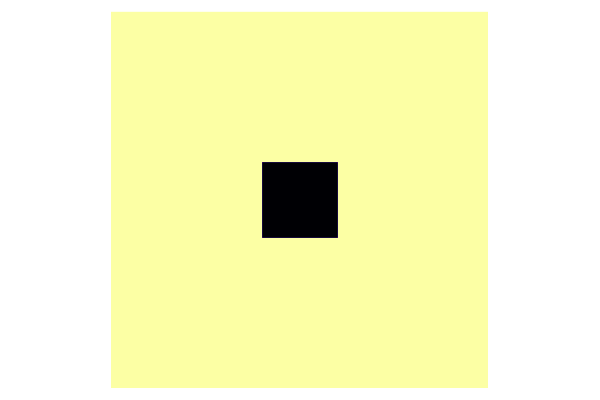

In [26]:
function run_simulation( grayscott_function, n = 300, maxiter = 10_000)
    u, v = init(n)
    Δu = zeros(n, n)
    Δv = zeros(n, n)
    options = (aspect_ratio = :equal, axis = nothing, 
               legend = :none, framestyle = :none)
    anim = @animate for t in 1:maxiter
        grayscott_function(u, v, Δu, Δv)
        heatmap(u; options...)
    end every 100
    return anim
end
run_simulation( grayscott!, 500, 1)
@time anim = run_simulation( grayscott!, 500, 5000)
gif(anim, "anim1.gif", fps = 15)

 24.687616 seconds (94.00 M allocations: 12.841 GiB, 3.99% gc time)


[ Info: Saved animation to /Users/navaro/JuliaProjects/CargoChatJulia2024/anim2.gif


Plots.AnimatedGif("/Users/navaro/JuliaProjects/CargoChatJulia2024/anim2.gif")
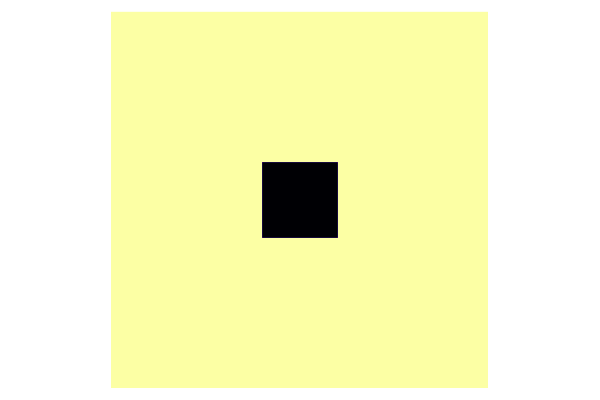

In [27]:
using .Threads

function grayscott_threads!( u, v, Δu, Δv)

    n = size(Δu,1)

    @threads for c = axes(Δu, 2)
        c1 = c + 1
        c2 = c + 2
        for r = axes(Δu, 1)
            r1 = r + 1
            r2 = r + 2
            @inbounds Δu[r,c] = u[r1,c2] + u[r1,c] + u[r2,c1] + u[r,c1] - 4*u[r1,c1]
            @inbounds Δv[r,c] = v[r1,c2] + v[r1,c] + v[r2,c1] + v[r,c1] - 4*v[r1,c1]
        end
    end

    @threads for c = axes(Δu, 2)
        c1 = c + 1
        for r = axes(Δu, 1)
            r1 = r + 1  
            @inbounds uvv = u[r1,c1]*v[r1,c1]*v[r1,c1]
            @inbounds u[r1,c1] +=  Dᵤ * Δu[r,c] - uvv + F*(1 - u[r1,c1])
            @inbounds v[r1,c1] +=  Dᵥ * Δv[r,c] + uvv - (F + k)*v[r1,c1]
        end
    end

end
run_simulation( grayscott_threads!, 500, 1)
@time anim = run_simulation( grayscott_threads!, 500, 5000)
gif(anim, "anim2.gif", fps = 15)

## Vectorized version

 32.733196 seconds (93.79 M allocations: 12.825 GiB, 3.08% gc time)


[ Info: Saved animation to /Users/navaro/JuliaProjects/CargoChatJulia2024/anim3.gif


Plots.AnimatedGif("/Users/navaro/JuliaProjects/CargoChatJulia2024/anim3.gif")
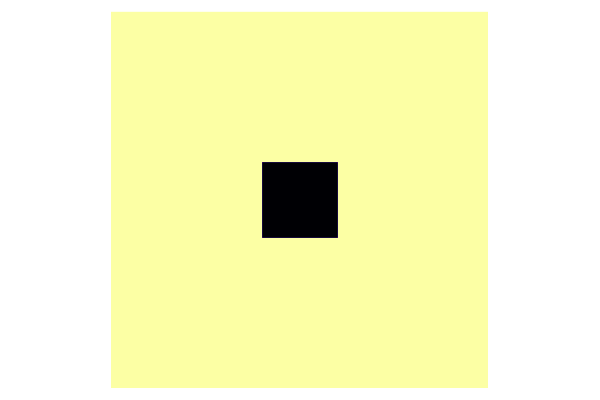

In [34]:
function grayscott_vectorized!(u, v, Δu, Δv, uvv)

   @views @. begin 
       Δu =(u[begin:end-2,2:end-1] + u[begin+1:end-1,1:end-2] + u[begin+1:end-1, begin+2:end] 
          + u[begin+2:end,2:end-1] - 4 * u[begin+1:end-1, begin+1:end-1] )
    
       Δv = (v[begin:end-2,2:end-1] + v[begin+1:end-1,1:end-2] + v[begin+1:end-1, begin+2:end] 
          + v[begin+2:end,begin+1:end-1] - 4 * v[begin+1:end-1, begin+1:end-1] )
    
       uvv = u[begin+1:end-1,begin+1:end-1] * v[begin+1:end-1,begin+1:end-1] * v[begin+1:end-1,begin+1:end-1]
    
       u[begin+1:end-1,begin+1:end-1] +=  Dᵤ * Δu - uvv + F * (1 - u[begin+1:end-1,begin+1:end-1])
    
       v[begin+1:end-1,begin+1:end-1] +=  Dᵥ * Δv + uvv - (F + k) * v[begin+1:end-1,begin+1:end-1]
   end

end

function run_simulation_vectorized( n = 300, maxiter = 10_000)
    u, v = init(n)
    Δu = zeros(n, n)
    Δv = zeros(n, n)
    uvv = zeros(n, n)
    options = (aspect_ratio = :equal, axis = nothing, 
               legend = :none, framestyle = :none)
    anim = @animate for t in 1:maxiter
        grayscott_vectorized!(u, v, Δu, Δv, uvv)
        heatmap(u; options...)
    end every 100
    return anim
end

run_simulation_vectorized( 500, 1)
@time anim = run_simulation_vectorized( 500, 5000)
gif(anim, "anim3.gif", fps = 15)

In [35]:
using CUDA

function run_on_gpu( n = 500, maxiter = 10_000)

    u0, v0 = init(n)

    u = CuArray(u0) # allocates on GPU
    v = CuArray(v0)

    Δu = CUDA.zeros(n, n)
    Δv = CUDA.zeros(n, n)
    uvv = CUDA.zeros(n, n)
    options = (aspect_ratio = :equal, axis = nothing, 
               legend = :none, framestyle = :none)
    
    for t in 1:maxiter
    
        grayscott_vectorized!(u, v, Δu, Δv, uvv)
        
        anim = @animate for t in 1:maxiter
            grayscott_vectorized!(u, v, Δu, Δv, uvv)
            heatmap(Array(u); options...)
        end every 100
        return anim

    end

    return anim

end

CUDA.@time anim = run_on_gpu( 500)
gif(anim, "anim3.gif", fps = 15)

LoadError: ArgumentError: Package CUDA not found in current path.
- Run `import Pkg; Pkg.add("CUDA")` to install the CUDA package.